# Plant Seedling Classification convolutionnal neural network
### DEBARD ROBALDO - IA option semester 8 - ENSEA

In [ ]:
import os, shutil
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from random import shuffle
from google.colab import drive


%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint


TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## I/ Data preprocessing



> Import datset and analyse its constitution



In [ ]:
#IMPORT DATASET
data_dir = '/content/drive/My Drive/TP_IA/TP4/TP4_ConvNets_IC_Keras_todo/plant_dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

IMG_SIZE = 224
length = 0

print('categories:', len(os.listdir(train_dir)))
for categories in os.listdir(train_dir):
    print(categories, ': ', len(os.listdir(os.path.join(train_dir,categories))))
    length = length + len(os.listdir(os.path.join(train_dir,categories)))

print('\ntotal train images:', length)
print('total test images:', len(os.listdir(os.path.join(test_dir,"test")))) 
#***********************NOTE: the test_dataset path has been changed for plant_dataset>test>test>test_dataset****************************
#you got to change the path on your drive in order to execute the code

categories: 12
Black-grass :  263
Charlock :  390
Cleavers :  287
Common Chickweed :  611
Maize :  221
Loose Silky-bent :  654
Scentless Mayweed :  516
Common wheat :  221
Sugar beet :  385
Fat Hen :  475
Small-flowered Cranesbill :  496
Shepherds Purse :  231

total train images: 4750
total test images: 794




> Initialise data generators for each set and subset.


> We'll not apply data augmentation for the training and we'll compare results of some architectures on the same not augmented dataset.


> We want picture to have the same size, so we set it with target_size argument (224*224)







In [ ]:
# All images will be rescaled by 1./255. We don't use data augmentation for the tests

train_datagen = image.ImageDataGenerator(rescale=1./255, validation_split=0.25)     #We use validation_split in order to create a sub "validation" dataset
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',                  #training subset
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical',           #one hot vector encoding: each category will correspond to a unique 12 bits vector
        shuffle=True)

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',                #validation subset
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical',           
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        class_mode=None,                    #undetermined classes for the moment
        shuffle=False)

#steps hyperparameters for generator_fit()
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
steps = test_generator.n//test_generator.batch_size


Found 3568 images belonging to 12 classes.
Found 1182 images belonging to 12 classes.
Found 794 images belonging to 1 classes.




> Check if everything is ok



In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 12)


## II/ ConvNet Model 1 (custom VGG16)

In [ ]:
image_input = Input(shape=(224,224,3))

vgg_base = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')

print('This is the number of trainable weights '
      'before freezing the conv base:', len(vgg_base.trainable_weights))

#fine tunning here: we only freeze the 2 first blocks
for layer in vgg_base.layers[:7]:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(vgg_base.trainable_weights))

vgg_base.summary()
#plot_model(vgg_base, show_shapes=True, show_layer_names=True)





58892288/58889256 [==============================] - 2s 0us/step






This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 18
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_____________________________________



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          294976    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
___

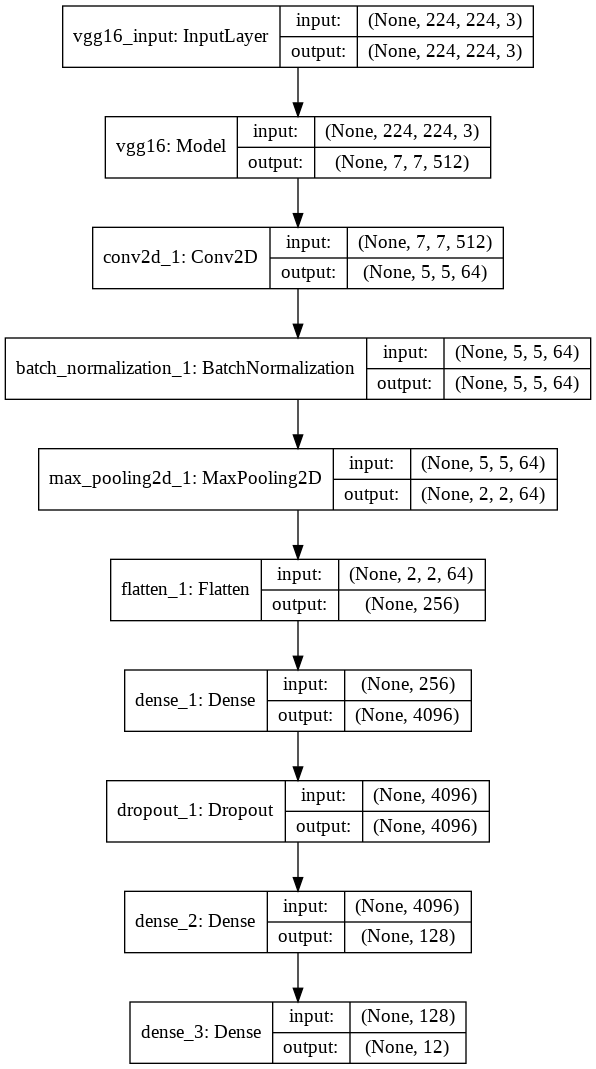

In [ ]:
#a total of 14 convolutions in this network

model1 = Sequential()

model1.add(vgg_base)

#additionnal convolution layer
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization(momentum = 0.95,beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#fully connected classifier
model1.add(Flatten())
model1.add(Dense(4096, activation='relu'))          #overfitted layer
model1.add(Dropout(0.4))                            #regularization due to overfitting
model1.add(Dense(128, activation='relu'))
model1.add(Dense(12, activation='softmax'))         #output layer 12 nodes: the size of the one hot output vector
                                                    #softmax activation takes in count the scores of other categories to compute the score of each category, contrary to sigmoid

keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])      #Multi-Class Cross-Entropy Loss

model1.summary()
plot_model(model1, show_shapes=True, show_layer_names=True)




> fit_generator to initiate the training



In [ ]:
history1 = model1.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      verbose=2)

Epoch 1/40
 - 61s - loss: 1.9565 - acc: 0.2874 - val_loss: 2.9014 - val_acc: 0.1892
Epoch 2/40
 - 62s - loss: 1.7914 - acc: 0.3500 - val_loss: 6.0718 - val_acc: 0.2052
Epoch 3/40
 - 60s - loss: 1.6979 - acc: 0.3871 - val_loss: 6.0093 - val_acc: 0.1617
Epoch 4/40
 - 60s - loss: 1.5599 - acc: 0.4369 - val_loss: 2.5092 - val_acc: 0.2974
Epoch 5/40
 - 59s - loss: 1.3710 - acc: 0.5110 - val_loss: 8.1206 - val_acc: 0.0826
Epoch 6/40
 - 58s - loss: 1.2886 - acc: 0.5344 - val_loss: 1.9707 - val_acc: 0.3878
Epoch 7/40
 - 58s - loss: 1.1031 - acc: 0.6191 - val_loss: 2.0887 - val_acc: 0.3730
Epoch 8/40
 - 58s - loss: 0.9879 - acc: 0.6458 - val_loss: 1.6709 - val_acc: 0.4148
Epoch 9/40
 - 58s - loss: 0.9368 - acc: 0.6605 - val_loss: 2.4749 - val_acc: 0.3748
Epoch 10/40
 - 57s - loss: 0.8642 - acc: 0.6884 - val_loss: 0.9303 - val_acc: 0.6739
Epoch 11/40
 - 57s - loss: 0.7852 - acc: 0.7196 - val_loss: 0.9246 - val_acc: 0.7061
Epoch 12/40
 - 55s - loss: 0.7247 - acc: 0.7449 - val_loss: 1.2010 - val_a

In [ ]:
model1.save('CNN_Plant_Model1.h5')

In [ ]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))


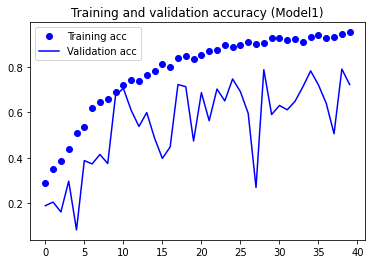

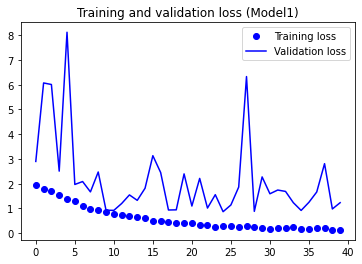

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model1)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Model1)')
plt.legend()

plt.show()

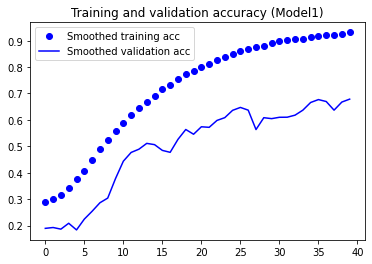

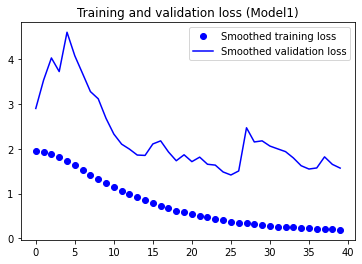

In [ ]:
#reducing the noise on the results, the behaviour seems not so stable on validation data

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy (Model1)')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss (Model1)')
plt.legend()

plt.show()

In [ ]:
#predictions on test train
test_generator.reset()

pred1 = model1.predict_generator(test_generator, steps=steps, verbose=1)

794/794 [==============================] - 289s 364ms/step


In [ ]:
predicted_class_indices = np.argmax(pred1,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#record predictions to csv file
filenames=test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results.to_csv('resultsModel1.csv')
!cp resultsModel1.csv "drive/My Drive/TP_IA/TP4/TP4_ConvNets_IC_Keras_todo/predictions_cnn_plant"

## III/ ConvNet Model 2 (InceptionV3 + fully connected classifier)

87916544/87910968 [==============================] - 8s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
batch_normalization_97 (Batc (None, 5, 5, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 12)                12300     
Total params: 23,921,452
Trainable params: 23,882,924
Non-trainable params: 38,528
_________________________________________________________________


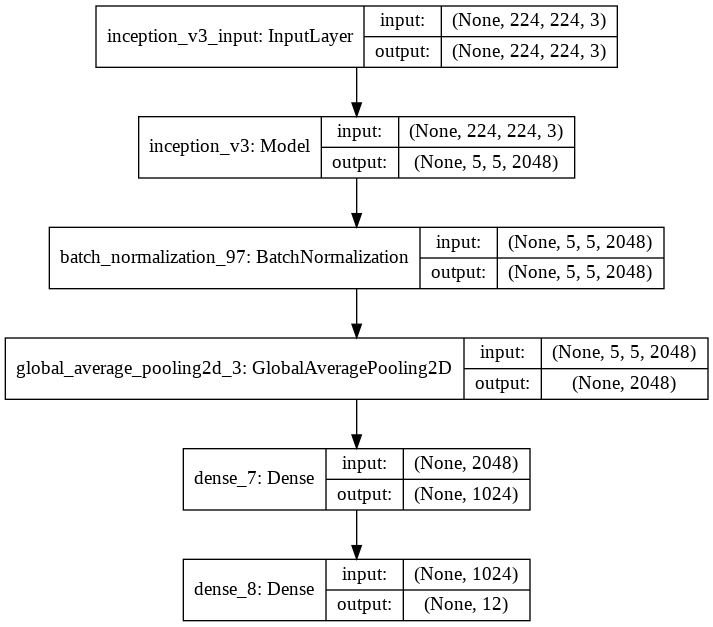

In [ ]:
image_input = Input(shape=(224,224,3))
inception_base = InceptionV3(input_tensor=image_input, weights='imagenet', include_top=False)

model2 = Sequential()

model2.add(inception_base)

model2.add(BatchNormalization(momentum = 0.9,beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
model2.add(GlobalAveragePooling2D())

#fully connected classifier WHY NO FLATTEN ???
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(12, activation='softmax'))

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
history2 = model2.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
 - 3010s - loss: 1.0881 - acc: 0.6731 - val_loss: 10.4279 - val_acc: 0.1493
Epoch 2/40
 - 62s - loss: 0.4868 - acc: 0.8429 - val_loss: 2.4474 - val_acc: 0.6209
Epoch 3/40
 - 61s - loss: 0.3330 - acc: 0.8913 - val_loss: 0.8004 - val_acc: 0.7896
Epoch 4/40
 - 60s - loss: 0.2734 - acc: 0.9113 - val_loss: 3.5414 - val_acc: 0.4183
Epoch 5/40
 - 61s - loss: 0.2717 - acc: 0.9102 - val_loss: 0.5117 - val_acc: 0.8504
Epoch 6/40
 - 60s - loss: 0.2228 - acc: 0.9268 - val_loss: 0.5941 - val_acc: 0.8365
Epoch 7/40
 - 59s - loss: 0.3886 - acc: 0.8891 - val_loss: 13.5577 - val_acc: 0.1426
Epoch 8/40
 - 59s - loss: 0.5483 - acc: 0.8407 - val_loss: 6.1116 - val_acc: 0.2678
Epoch 9/40
 - 59s - loss: 0.2707 - acc: 0.9071 - val_loss: 4.1563 - val_acc: 0.4809
Epoch 10/40
 - 59s - loss: 0.2475 - acc: 0.9189 - val_loss: 1.0800 - val_acc: 0.7470
Epoch 11/40
 - 59s - loss: 0.1932 - acc: 0.9347 - val_loss:

In [ ]:
model2.save('CNN_Plant_Model2.h5')



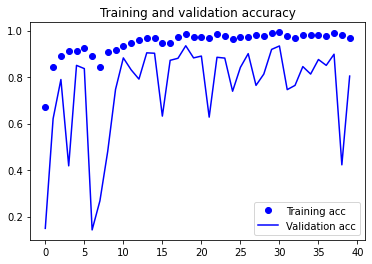

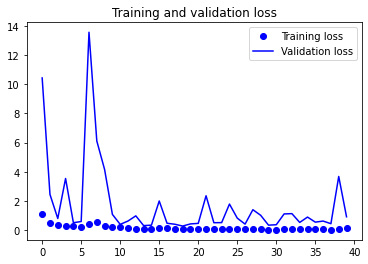

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

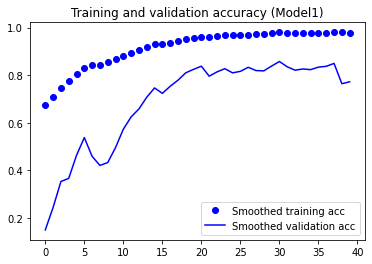

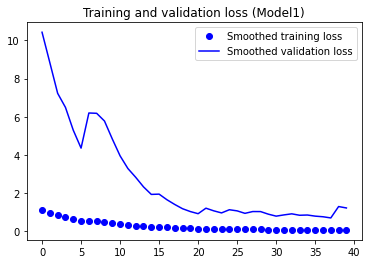

In [ ]:
#reducing the noise on the results, the behaviour seems not so stable on validation data

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy (Model1)')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss (Model1)')
plt.legend()

plt.show()

In [ ]:
#predictions on test train
test_generator.reset()

pred2 = model2.predict_generator(test_generator, steps=steps, verbose=1)

794/794 [==============================] - 496s 625ms/step


In [ ]:
predicted_class_indices = np.argmax(pred2,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results.to_csv('resultsModel2.csv')
!cp resultsModel2.csv "drive/My Drive/TP_IA/TP4/TP4_ConvNets_IC_Keras_todo/predictions_cnn_plant"

# IV/Conv Net Model 3 (Resnet base)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_98 (Batc (None, 7, 7, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_11 (Dense)             (None, 12)                3084      
Total params: 25,959,564
Trainable params: 25,902,348
Non-trainable params: 57,216
_____________________________________

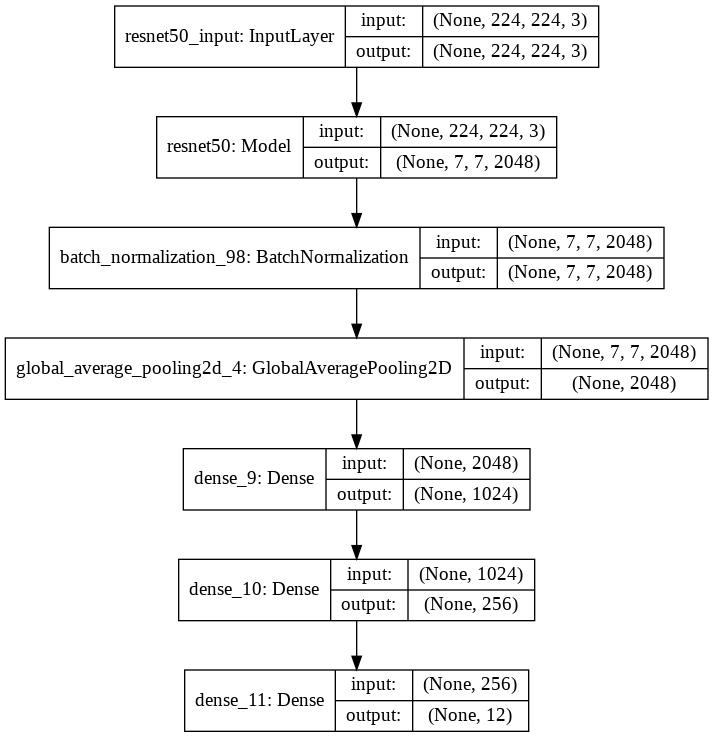

In [ ]:
image_input = Input(shape=(224,224,3))
resnet_base = ResNet50(input_tensor=image_input, include_top=False, weights='imagenet')

model3 = Sequential()

model3.add(resnet_base)

model3.add(BatchNormalization(momentum = 0.9,beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros'))
model3.add(GlobalAveragePooling2D())

#fully connected classifier WHY NO FLATTEN ???
model3.add(Dense(1024, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(12, activation='softmax'))

model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

model3.summary()
plot_model(model3, show_shapes=True, show_layer_names=True)

In [ ]:
history3 = model3.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      verbose=2)

Epoch 1/40
 - 118s - loss: 0.3587 - acc: 0.8691 - val_loss: 1.8849 - val_acc: 0.5174
Epoch 2/40
 - 122s - loss: 0.3554 - acc: 0.8753 - val_loss: 1.3317 - val_acc: 0.6643
Epoch 3/40
 - 121s - loss: 0.2560 - acc: 0.9147 - val_loss: 2.5126 - val_acc: 0.5296
Epoch 4/40
 - 121s - loss: 0.2332 - acc: 0.9144 - val_loss: 1.5835 - val_acc: 0.6878
Epoch 5/40
 - 120s - loss: 0.1909 - acc: 0.9333 - val_loss: 2.4530 - val_acc: 0.5313
Epoch 6/40
 - 120s - loss: 0.1391 - acc: 0.9527 - val_loss: 0.4305 - val_acc: 0.8826
Epoch 7/40
 - 119s - loss: 0.1568 - acc: 0.9499 - val_loss: 3.7269 - val_acc: 0.4270
Epoch 8/40
 - 119s - loss: 0.2000 - acc: 0.9316 - val_loss: 1.3089 - val_acc: 0.7087
Epoch 9/40
 - 119s - loss: 0.1226 - acc: 0.9552 - val_loss: 1.2090 - val_acc: 0.6870
Epoch 10/40
 - 120s - loss: 0.1530 - acc: 0.9507 - val_loss: 1.3678 - val_acc: 0.7078
Epoch 11/40
 - 118s - loss: 0.0793 - acc: 0.9710 - val_loss: 1.1249 - val_acc: 0.7217
Epoch 12/40
 - 118s - loss: 0.1211 - acc: 0.9620 - val_loss: 2.

In [ ]:
model3.save('CNN_Plant_Model3.h5')



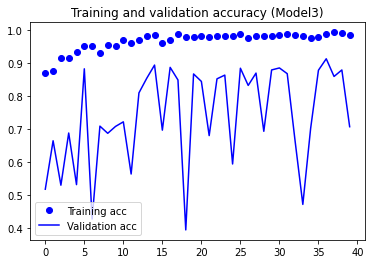

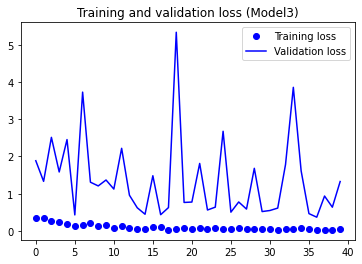

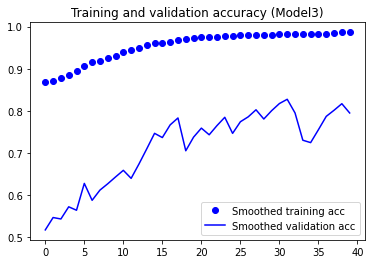

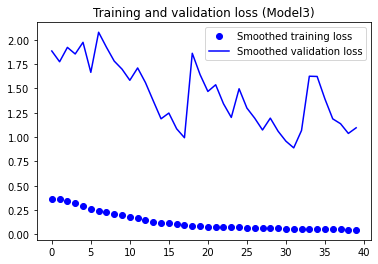

In [ ]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Model3)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Model3)')
plt.legend()

plt.show()

#reducing the noise on the results, the behaviour seems not so stable on validation data

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy (Model3)')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss (Model3)')
plt.legend()

plt.show()

In [ ]:
#predictions on test train
test_generator.reset()

pred3 = model3.predict_generator(test_generator, steps=steps, verbose=1)

predicted_class_indices = np.argmax(pred3,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results.to_csv('resultsModel3.csv')
!cp resultsModel3.csv "drive/My Drive/TP_IA/TP4/TP4_ConvNets_IC_Keras_todo/predictions_cnn_plant"

794/794 [==============================] - 493s 621ms/step
